In [1]:
base_dir = '/home/users/delon/aemulus_nu/'

In [2]:
import numpy as np
cosmos = {}

tier1_fname = base_dir+'tier1_cosmos.txt'
f = open(tier1_fname, 'r')
columns = [col[:-1] for col in f.readline().strip().split()[1:]]
print(columns)
i = 0
for line in f:
    box_name = 'Box%d_1400'%(i)
    assert(len(line.split()) == len(columns))
    cosmos[box_name] = dict(zip(columns, np.array(line.split(), dtype=np.float64)))
    i+=1
f.close()


tier2_fname = base_dir+'tier2_cosmos.txt'
f = open(tier2_fname, 'r')
columns = [col[:-1] for col in f.readline().strip().split()[1:]]
print(columns)
i = 0
for line in f:
    box_name = 'Box_n50_%d_1400'%(i)
    assert(len(line.split()) == len(columns))
    cosmos[box_name] = dict(zip(columns, np.array(line.split(), dtype=np.float64)))
    i+=1
f.close()

['As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev', 'sigma']
['As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev', 'sigma']


In [3]:
from utils import *
import numpy as np

In [4]:
from tqdm import tqdm, trange
from classy import Class
import pickle

pbar = tqdm(cosmos)

for key in pbar:
    if('63' in key):
        continue
    if(key != 'Box_n50_0_1400' and key != 'Box0_1400'):
        continue
    pbar.set_description(key)

    cosmo = cosmos[key]
    h = cosmo['H0']/100
    cosmo_dict = {
        'h': h,
        'Omega_b': cosmo['ombh2'] / h**2,
        'Omega_cdm': cosmo['omch2'] / h**2,
        'N_ur': 0.00641,
        'N_ncdm': 1,
        'output': 'mPk mTk',
        'z_pk': '0.0,99',
        'P_k_max_h/Mpc': 20.,
        'm_ncdm': cosmo['nu_mass_ev']/3,
        'deg_ncdm': 3,
        'T_cmb': 2.7255,
        'A_s': cosmo['As'] * 10**-9,
        'n_s': cosmo['ns'],
        'Omega_Lambda': 0.0,
        'w0_fld': cosmo['w0'],
        'wa_fld': 0.0,
        'cs2_fld': 1.0,
        'fluid_equation_of_state': "CLP"
    }
    pkclass = Class()
    pkclass.set(cosmo_dict)
    pkclass.compute()
    
    curr_run_fname = '/oak/stanford/orgs/kipac/aemulus/aemulus_nu/%s/'%(key)
    rockstar_dir = curr_run_fname+'output/rockstar/'

    f = open(rockstar_dir+'savelist.txt', 'r')
    savelist = f.read().split()
    f.close()

    N_snapshots = len(savelist)
    a = []
    for i in range(N_snapshots):
        f = open(rockstar_dir+'out_%d.list'%(i), 'r')

        for line in f:
            if('#a' in line):
                a+= [eval(line.split()[2])]
                break


    zs = [scaleToRedshift(a_curr) for a_curr in a]

    Pkz = {}
    for z in  zs:
        kt = np.logspace(-3, 1, 100) # h/Mpc
        pk_m_lin = np.array(
            [
                pkclass.pk_lin(ki, np.array([z]))*h**3 #units of Mpc^3/h^3
                for ki in kt * h # 1 / Mpc
            ]
        )
        from scipy.interpolate import interp1d
        #given k in units of h/Mpc gives Pk in units of Mpc^3/h^3 
        Pk = interp1d(kt, pk_m_lin, kind='linear', bounds_error=False, fill_value=0.)

        Pkz[z] = Pk    
        class_sigma8 = pkclass.sigma(8, z, h_units=True)
        my_sigma8 = np.sqrt(sigma2(Pk, 8)) # 8 h^-1 Mpc
        print(class_sigma8, my_sigma8)
        assert(np.abs(class_sigma8-my_sigma8)<0.01*class_sigma8)
#         plt.plot(kt, Pk(kt))
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.show()
    
    Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+key+'_Pk.pkl'
    Pk_f = open(Pk_fname, 'wb')
    pickle.dump(Pkz, Pk_f)
    Pk_f.close()


Box0_1400:   0%|          | 0/150 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/Cosmo.py:43: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


0.22152019295462502 0.22176713017635194
0.26789887474624907 0.26819751309872625
0.3237099415230242 0.32407079647840914
0.35562162150543597 0.3560180396490009
0.42823739422511065 0.4287147724679537
0.4482838948717976 0.4487836201362495
0.4690838306232499 0.46960674400779373
0.49062097071780897 0.4911678943637824
0.5128661283321296 0.5134378510083936
0.5357769823635478 0.5363742450893266
0.5592949183191871 0.5599184107382289
0.6078336838520216 0.608511299669242
0.657663457984701 0.6583966391182577
0.7076970452111038

Box_n50_0_1400:   1%|          | 1/150 [00:02<05:33,  2.24s/it]

 0.7084860157178505
0.7566707616701037 0.7575143615735112
0.7803537284512393 0.7812237133677598
0.25630202060064 0.2566404373837329
0.3086967168327113 0.30910432456401277
0.3705814302996405 0.3710707611294076
0.4052703607438186 0.4058055015207293
0.48199914602689076 0.4826356261928661
0.5025990846225155 0.5032627716230755
0.5236972211673856 0.5243887717742812
0.545245658073222 0.5459656648844109
0.5671867304967159 0.5679357108081903
0.589454828155442 0.590233214324848
0.6119759197605941 0.6127840452258568
0.6574482457499445 0.6583164064709179
0.7028952134790456 0.7038233721152627


Box_n50_0_1400: 100%|██████████| 150/150 [00:04<00:00, 36.55it/s]

0.7475668957709927 0.7485540581707121
0.7907338862886181 0.7917780724726708
0.8115460908464522 0.8126177736945536


In [5]:
pkclass.sigma(8, z, h_units=True)

0.8115460908464522

In [6]:
np.sqrt(sigma2(Pk, 8))

0.8126177736945536

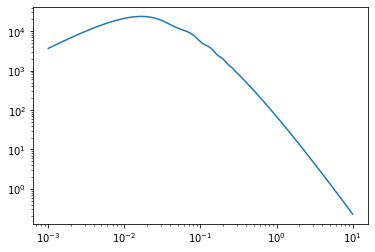

In [7]:
plt.plot(kt, Pk(kt))
plt.xscale('log')
plt.yscale('log')